In [2]:
import bempp.api
import numpy as np
import scipy
import math
import time
import scipy.linalg 
import scipy.linalg.interpolative as sli
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

from bempp.api.assembly.blocked_operator import BlockedOperator
from numpy.linalg import slogdet
bempp.api.set_default_device(0, 0)
#bempp.api.enable_console_logging()

Sphere-Sphere case 

In [3]:
h = .2   # size of the mesh (element)
center1 = (1.5, 0, 0) # center of one sphere
center2 = (-1.5, 0, 0) # center of the other sphere

sphere1 = bempp.api.shapes.sphere(h=h, origin=center1)
sphere2 = bempp.api.shapes.sphere(h=h, origin=center2)

In [4]:
rwg1_ss = bempp.api.function_space(sphere1, "RWG", 0)
rwg2_ss = bempp.api.function_space(sphere2, "RWG", 0)

snc1_ss = bempp.api.function_space(sphere1, "SNC", 0)
snc2_ss = bempp.api.function_space(sphere2, "SNC", 0)

#### Construct $A_{1} = \begin{bmatrix}
I & M_{11}^{-1}M_{12}\\
M_{22}^{-1} & I
\end{bmatrix}$   and $A_{2} = I - M_{11}^{-1}M_{12}M_{22}^{-1}M_{21}$. The relation $\det(A_{1}) = \det(A_{2})$ holds. We calculate the $\log\det$ of these two matrices and compare the relative error with different approximaton ranks.

In [23]:
wavenumber = 1j * 2

op11 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg1_ss, snc1_ss, wavenumber)
op22 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg2_ss, snc2_ss, wavenumber)
op21 = bempp.api.operators.boundary.maxwell.electric_field(rwg1_ss, rwg2_ss, snc2_ss, wavenumber)
op12 = bempp.api.operators.boundary.maxwell.electric_field(rwg2_ss, rwg1_ss, snc1_ss, wavenumber)

mat11 = np.real(op11.weak_form().A)
mat12 = np.real(op12.weak_form().A)
mat21 = np.real(op21.weak_form().A)
mat22 = np.real(op22.weak_form().A)
ident_mat = np.identity(mat11.shape[0])

A1 = ident_mat - np.linalg.inv(mat11)@mat12@np.linalg.inv(mat22)@mat21 #-------------This is A1----------------------

sign1, logdet1 = slogdet(A1)
result1 = logdet1

mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat1 = np.real(np.block([[mat11,mat12],[mat21,mat22]]))    
mat2 = np.real(np.block([[mat11,mat12_zero],[mat21_zero,mat22]]))

A2 = np.linalg.inv(mat2).dot(mat1) #-------------------This is A2--------------------------------

sign2, logdet2 = slogdet(A2)
result2 = logdet2

In [27]:
result1

-0.001850107730125435

In [28]:
result2

-0.0018501077299057425

In [24]:
n1 = A1.shape[0]
n2 = A2.shape[0]

In [25]:
print(n1,n2)

1269 2538


In [26]:
nboxes1 = 27
nboxes2 = 47
size1 = n1//nboxes1
size2 = n2//nboxes2

In [29]:
def get_box(nx, ny, A, nboxes, n):
    """Return the content of a given box"""
    size = n // nboxes
    xrange = [nx * size, (1 + nx) * size] 
    yrange = [ny * size, (1 + ny) * size] 
    return A[xrange[0]:xrange[1], yrange[0]:yrange[1]] 

In [30]:
def get_con_box(i,A,nboxes,n):
    """Return Ai"""
    size = n // nboxes
    BB = A[i * size : (i + 1) * size, :]
    B = np.delete(BB, np.s_[i*size : (i+1)*size], axis = 1)
    
    CC = np.transpose(A[:, i * size : (i + 1) * size])
    C = np.delete(CC, np.s_[i*size : (i+1)*size], axis = 1)
    return np.hstack((B,C))

In [31]:
def plot_box_ranks(A, nboxes, n, tol=1E-8):
    """Plot rank of the boxes."""
    from scipy.linalg import svdvals
    ranks = np.zeros((nboxes,nboxes),dtype='int32')
    for i in range(nboxes):
        for j in range(nboxes):
            m = get_box(i, j, A, nboxes, n)
            s = svdvals(m)
            ranks[i,j] = np.sum(s>tol)
    plt.imshow(ranks, cmap='Accent')
    plt.colorbar()

<Figure size 432x288 with 0 Axes>

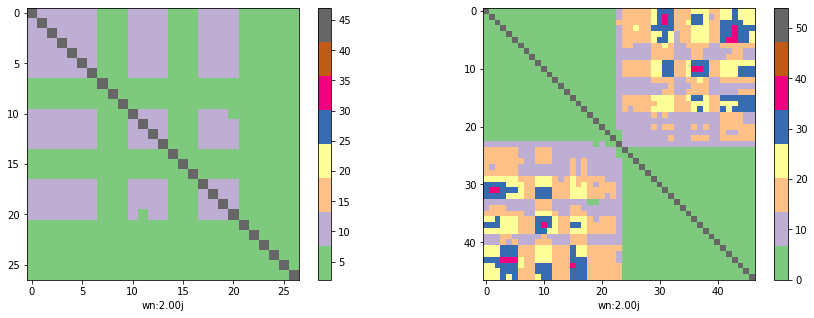

In [32]:
fig = plt.figure()
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plot_box_ranks(A1,nboxes1,n1)
plt.xlabel('wn:%.2fj' % (2))

plt.subplot(1,2,2)
plot_box_ranks(A2,nboxes2,n2)
plt.xlabel('wn:%.2fj' % (2))

plt.show()

In [33]:
def L(i,k,A,nboxes,n):
    idx1,proj1 = sli.interp_decomp(get_con_box(i,A,nboxes,n), k, rand = False)
    B1 = sli.reconstruct_skel_matrix(get_con_box(i,A,nboxes,n),k,idx1)
    B1_trans = np.transpose(B1)
    
    idx2,proj2 = sli.interp_decomp(B1_trans, k, rand = False)
    P2_trans = sli.reconstruct_interp_matrix(idx2,proj2)

    P2 = np.transpose(P2_trans)
    return P2,idx2

In [34]:
def index_set(k,A,nboxes,n):
    l = []
    for i in range(nboxes):
        l.append(L(i,k,A,nboxes,n)[1][0:k])
    return l

In [35]:
def SSS(k,A,nboxes,n):
    ll = index_set(k,A,nboxes,n)
    mat = np.zeros((k*nboxes,k*nboxes))
    for i in range(nboxes):
        for j in range(nboxes):
            if i != j:
                mat_ =  get_box(i,j,A,nboxes,n)[ll[i],:]
                mat[i*k:(i+1)*k,j*k:(j+1)*k] = mat_[:,ll[j]]
    return mat

In [36]:
def R(i,k,A,nboxes,n):
    RR = np.transpose(L(i,k,A,nboxes,n)[0])
    return RR

In [37]:
def new_S(k,A,nboxes,n):
    mat_ = SSS(k,A,nboxes,n)
    for i in range(nboxes):
        mat_[i*k:(i+1)*k,i*k:(i+1)*k] = np.linalg.inv(R(i,k,A,nboxes,n) @ np.linalg.inv(get_box(i,i,A,nboxes,n)) @ L(i,k,A,nboxes,n)[0])
    return mat_

In [38]:
def logdet_method2(k,A,nboxes,n):
    size = n//nboxes
    a1 = 0
    p1,l1,u1 = scipy.linalg.lu(new_S(k,A,nboxes,n))
    for i in range(k*nboxes):
        a1 += math.log(abs(u1[i,i]))
        
    a2 = 0
    for i in range (nboxes):
        p2,l2,u2 = scipy.linalg.lu(get_box(i,i,A,nboxes,n))
        for j in range(size):
            a2 +=math.log(abs(u2[j,j]))
            
    a3 = 0
    for i in range(nboxes):
        p3,l3,u3 = scipy.linalg.lu(-R(i,k,A,nboxes,n)@np.linalg.inv(get_box(i,i,A,nboxes,n)) @L(i,k,A,nboxes,n)[0] )
        for j in range(k):
            a3 += math.log(abs(u3[j,j]))
    return a1 + a2 + a3

In [39]:
wn_logdet1 = np.empty(size1)
for i in range(1,size1 + 1 ):
    wn_logdet1[i-1] = logdet_method2(i,A1,nboxes1,n1)

In [40]:
wn_err1 = np.empty(size1)
for i in range(size1):
    wn_err1[i] = abs((result1 - wn_logdet1[i])/result1)

In [41]:
wn_err1

array([1.40407096e-04, 8.65896281e-05, 4.26600048e-05, 7.18403431e-06,
       9.45171778e-07, 8.38290572e-08, 7.46216035e-07, 4.80803450e-07,
       4.32243563e-07, 4.27505568e-08, 1.07829645e-07, 3.02813020e-08,
       3.73059018e-09, 3.79316734e-08, 3.61253740e-09, 9.56822299e-09,
       9.84958719e-09, 2.90587659e-09, 4.56499328e-09, 3.55752784e-10,
       4.17201550e-10, 1.05112964e-10, 1.40682101e-10, 4.36641980e-11,
       2.58734880e-10, 3.81632413e-10, 3.86477167e-10, 2.63579634e-10,
       7.43885812e-11, 4.36641980e-11, 2.32855251e-10, 4.47925933e-10,
       4.85089516e-11, 1.35837348e-10, 7.92333348e-11, 4.36641980e-11,
       5.90263896e-11, 4.36641980e-11, 9.45955264e-11, 1.40682101e-10,
       7.43885812e-11, 1.77845684e-11, 1.51199539e-10, 1.05112964e-10,
       1.77845684e-11, 2.42237683e-12, 9.56339558e-12])

In [42]:
wn_logdet2 = np.empty(size2)
for i in range(1,size2 + 1 ):
    wn_logdet2[i-1] = logdet_method2(i,A2,nboxes2,n2)

In [43]:
wn_err2 = np.empty(size2)
for i in range(size2):
    wn_err2[i] = abs((result2 - wn_logdet2[i])/result2)

In [44]:
wn_err2

array([6.53405219e-01, 5.59969925e-02, 1.21454617e-02, 1.40334961e-02,
       2.30430368e-02, 1.20764252e-02, 9.11701132e-03, 5.33315623e-03,
       5.49336741e-04, 1.83674785e-03, 3.88645720e-03, 3.45933700e-03,
       2.03096877e-04, 2.95937544e-04, 5.67614997e-04, 3.32356797e-04,
       4.44456079e-04, 1.65527593e-04, 4.38177042e-04, 9.87938021e-05,
       5.05328223e-08, 4.03120104e-05, 8.44026854e-05, 2.81393960e-05,
       6.25913228e-05, 2.63300195e-05, 2.54218858e-05, 9.80202191e-06,
       9.17206673e-06, 7.09645030e-06, 1.13488103e-05, 1.98518578e-06,
       9.92872927e-06, 5.43475276e-06, 3.89976257e-06, 1.75358538e-06,
       5.01553170e-06, 2.38720119e-06, 1.95102027e-06, 2.40991966e-06,
       7.57500880e-07, 2.32794700e-06, 4.60321497e-07, 1.41613948e-06,
       6.04391540e-09, 2.90538556e-07, 3.09262853e-07, 2.30362637e-07,
       3.51136777e-09, 1.54934276e-07, 1.29709558e-07, 8.05121392e-08,
       1.68204928e-08, 1.21142282e-12])

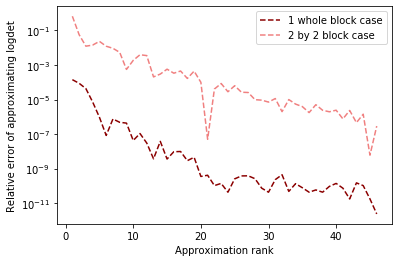

In [45]:
rk = np.linspace(1,size1-1,size1-1)

vocabulary = [1 , 2 , 3 ]
my_colors = {1:'darkred',2:'red',3:'lightcoral'}

plt.semilogy(rk , wn_err1[0:size1-1], color = my_colors.get(vocabulary[0]), linestyle='--')
plt.semilogy(rk , wn_err2[0:size1-1], color = my_colors.get(vocabulary[2]), linestyle='--')
plt.legend(['1 whole block case','2 by 2 block case'])
plt.xlabel('Approximation rank')
plt.ylabel('Relative error of approximating logdet')
plt.savefig('Compare h=0.2,Z=1.0.pdf')